In [1]:
# Cell 0 - GPU check
!nvidia-smi || echo "No GPU detected - please set Runtime -> Change runtime type -> GPU"


Mon Sep 15 11:01:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Cell 1 - install libs
!pip install -q -U "transformers>=4.34.0" datasets accelerate peft bitsandbytes safetensors evaluate sentencepiece


import transformers, datasets, accelerate, peft, sys
print("transformers", transformers.__version__)
print("datasets", datasets.__version__)
print("accelerate", accelerate.__version__)
print("peft", peft.__version__)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.4 MB/s eta 0:00:00
transformers 4.56.1
datasets 4.0.0
accelerate 1.10.1
peft 0.17.1


In [3]:
# Cell 2 - upload dataset files
from google.colab import files
uploaded = files.upload()  # select train.jsonl & valid.jsonl (or all.jsonl)
print("Uploaded:", list(uploaded.keys()))


Saving train.jsonl to train.jsonl
Saving valid.jsonl to valid.jsonl
Uploaded: ['train.jsonl', 'valid.jsonl']


In [4]:
# Cell 3 - check and auto-fix swapped train/valid if sizes were swapped
import os, itertools

def count_lines(path):
    if not os.path.exists(path): return 0
    with open(path,'r',encoding='utf-8') as f:
        return sum(1 for _ in f)

# If user uploaded all.jsonl, split it
if os.path.exists("all.jsonl") and not (os.path.exists("train.jsonl") or os.path.exists("valid.jsonl")):
    from datasets import load_dataset
    ds = load_dataset("json", data_files={"all":"all.jsonl"})["all"]
    split = ds.train_test_split(test_size=0.1, seed=42)
    split["train"].to_json("train.jsonl", orient="records", lines=True)
    split["test"].to_json("valid.jsonl", orient="records", lines=True)
    print("Split all.jsonl into train.jsonl and valid.jsonl")

train_count = count_lines("train.jsonl")
valid_count = count_lines("valid.jsonl")
print("Before fix - train.jsonl:", train_count, "valid.jsonl:", valid_count)

# If both exist and train is smaller than valid, swap them (common accidental swap)
if train_count > 0 and valid_count > 0 and train_count < valid_count:
    print("Detected train smaller than valid → swapping files so train becomes the larger file.")
    os.rename("train.jsonl", "tmp_small.jsonl")
    os.rename("valid.jsonl", "train.jsonl")
    os.rename("tmp_small.jsonl", "valid.jsonl")

train_count = count_lines("train.jsonl")
valid_count = count_lines("valid.jsonl")
print("After fix - train.jsonl:", train_count, "valid.jsonl:", valid_count)

# show first line of each
def show_first(path):
    if not os.path.exists(path):
        print(path, "missing")
        return
    with open(path,'r',encoding='utf-8') as f:
        print("---", path, "first line ---")
        print(f.readline().strip())

show_first("train.jsonl")
show_first("valid.jsonl")


Before fix - train.jsonl: 50 valid.jsonl: 450
Detected train smaller than valid → swapping files so train becomes the larger file.
After fix - train.jsonl: 450 valid.jsonl: 50
--- train.jsonl first line ---
{"prompt": "Instruction: Draft an email to a professor asking for a 3-day extension on an assignment due to illness. Include polite tone, class name, and mention you will submit by the new date.", "completion": "Subject: Request for 3-day extension on Biomechanics assignment\n\nDear Dr. Kapoor,\n\nI hope you are well. I am writing to request a 3-day extension for the homework for Biomechanics currently due on September 19, 2025. I have been unwell and, as a result, was unable to work on the assignment this week to the standard I aim for. I respectfully request permission to submit the homework by September 22, 2025. I assure you I will submit it by that date and complete it to the best of my ability.\n\nThank you for your understanding and consideration.\n\nSincerely,\nNeha Roll No.

In [5]:
# Cell 4 - write train_lora.py
%%writefile train_lora.py
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import torch

# ==== Edit these if needed ====
MODEL_NAME = "distilgpt2"   # small & runs on 8GB
OUTPUT_DIR = "lora-output"
TRAIN_FILE = "train.jsonl"
VALID_FILE = "valid.jsonl"
BATCH_SIZE = 2
EPOCHS = 3
MAX_LENGTH = 512
GRADIENT_ACCUM_STEPS = 4
LEARNING_RATE = 2e-4
# ==============================

if not (os.path.exists(TRAIN_FILE) and os.path.exists(VALID_FILE)):
    raise FileNotFoundError("Please upload train.jsonl and valid.jsonl into Colab working dir.")

dataset = load_dataset("json", data_files={"train": TRAIN_FILE, "validation": VALID_FILE})

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def preprocess_batch(batch):
    texts = [p + c for p, c in zip(batch["prompt"], batch["completion"])]
    return tokenizer(texts, truncation=True, padding="max_length", max_length=MAX_LENGTH)

tokenized = dataset.map(preprocess_batch, batched=True, remove_columns=dataset["train"].column_names)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUM_STEPS,
    num_train_epochs=EPOCHS,
    logging_steps=50,
    learning_rate=LEARNING_RATE,
    fp16=True,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=data_collator,
)

trainer.train()

print("Running evaluation on validation set...")
metrics = trainer.evaluate(eval_dataset=tokenized["validation"])
print("Evaluation metrics:", metrics)

model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("✅ Training complete. Saved to", OUTPUT_DIR)


Writing train_lora.py


In [7]:
# Cell 5 - confirm presence of files and script
!ls -lh train.jsonl valid.jsonl train_lora.py || true
!head -n 2 train.jsonl || true
!head -n 2 valid.jsonl || true


-rw-r--r-- 1 root root 385K Sep 15 11:03 train.jsonl
-rw-r--r-- 1 root root 2.4K Sep 15 11:04 train_lora.py
-rw-r--r-- 1 root root  43K Sep 15 11:03 valid.jsonl
{"prompt": "Instruction: Draft an email to a professor asking for a 3-day extension on an assignment due to illness. Include polite tone, class name, and mention you will submit by the new date.", "completion": "Subject: Request for 3-day extension on Biomechanics assignment\n\nDear Dr. Kapoor,\n\nI hope you are well. I am writing to request a 3-day extension for the homework for Biomechanics currently due on September 19, 2025. I have been unwell and, as a result, was unable to work on the assignment this week to the standard I aim for. I respectfully request permission to submit the homework by September 22, 2025. I assure you I will submit it by that date and complete it to the best of my ability.\n\nThank you for your understanding and consideration.\n\nSincerely,\nNeha Roll No. 540552\nBiomechanics"}
{"prompt": "Instructio

In [8]:
# Cell 6 - run training (explicit flags to force fp16)
!accelerate launch --num_processes 1 --num_machines 1 --mixed_precision fp16 --dynamo_backend no train_lora.py


2025-09-15 11:06:10.423283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757934370.462139    1885 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757934370.473393    1885 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757934370.500865    1885 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757934370.500921    1885 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757934370.500932    1885 computation_placer.cc:177] computation placer alr

In [10]:
# Recommended: normal run (no synchronous CUDA debugging)
!WANDB_MODE=disabled accelerate launch --num_processes 1 --num_machines 1 --mixed_precision fp16 --dynamo_backend no train_lora.py


2025-09-15 11:10:52.299379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757934652.320848    3119 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757934652.327012    3119 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757934652.342812    3119 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757934652.342835    3119 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757934652.342839    3119 computation_placer.cc:177] computation placer alr

In [12]:
# Colab cell: load tokenizer, resize base embeddings, then load PEFT adapter
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch

MODEL_NAME = "distilgpt2"
ADAPTER_DIR = "lora-output"
device = "cuda" if torch.cuda.is_available() else "cpu"

# load tokenizer from the adapter folder (this has the added pad token)
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR)

# load base model
base = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

# resize base embeddings to match tokenizer length (important!)
if base.get_input_embeddings().weight.size(0) != len(tokenizer):
    print("Resizing base embeddings from", base.get_input_embeddings().weight.size(0), "to", len(tokenizer))
    base.resize_token_embeddings(len(tokenizer))

# now load the peft adapter onto the resized base
model = PeftModel.from_pretrained(base, ADAPTER_DIR)
model = model.to(device)
model.eval()

# quick generation function
def draft_email(prompt, max_new_tokens=200, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=0.95,
        temperature=temperature,
        pad_token_id=tokenizer.pad_token_id
    )
    # remove prompt part from generated output
    gen = tokenizer.decode(out[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    return gen

# test
prompt = "Instruction: Draft a polite email requesting a 3-day extension for an assignment due to illness.\n\n###\n"
print(draft_email(prompt))


Resizing base embeddings from 50257 to 50258


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Dear Dr. Lasson,


I would like to extend my request for an internship at Microsoft. I am currently writing a letter to Dr. Lasson on behalf of my research project and would be honored if it could be transcribed. I am extremely honored to be able to work on my project and could write it on your behalf.

Thank you for taking this opportunity to transcribe my research and write it on my behalf.

Sincerely,


Sharon
Associate Professor
Microsoft Research

17.09.2014
Dear Dr. Lasson,
I appreciate your consideration and interest in transcribing my research. I appreciate your interest in transcribing my research and would be honored if it could be transcribed.

Thank you for understanding and consideration of transcribing my research and I hope you can contribute to my research.


Thank you for your understanding and consideration of transcribing my research and I hope you can


In [15]:
def draft_email(prompt, max_new_tokens=200, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=0.9,                # nucleus sampling, avoids nonsense
        temperature=temperature,  # controls creativity
        repetition_penalty=1.3,   # reduces repetition
        no_repeat_ngram_size=3,   # blocks repeated phrases
        pad_token_id=tokenizer.pad_token_id
    )
    gen = tokenizer.decode(out[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    return gen

# test again
prompt = "Instruction: Draft a polite email requesting a 3-day extension for an assignment due to illness.\n\n###\n"
print(draft_email(prompt))


Dear Dr. Roshan Sharma,

I am currently writing letter of intent on receiving the application by completing my online research course at Google Engineering in 2015 and applying it as I planned with time until October 20 . We appreciate your understanding about our request and would share any information you may have regarding this decision without further comment or word. While we are studying engineering from 2013 to 2014, please consider sharing if possible—we hope that helps us become even more productive when pursuing such assignments once again!


In [16]:
def draft_email(prompt, max_new_tokens=200, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=0.9,                 # nucleus sampling
        temperature=temperature,   # creativity control
        repetition_penalty=1.3,    # reduce loops
        no_repeat_ngram_size=4,    # stricter: avoid repeating 4-word chunks
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    gen = tokenizer.decode(out[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)

    # 🧹 Cleanup: stop after common polite endings
    for stop in ["Sincerely", "Best regards", "Regards", "Thank you"]:
        if stop in gen:
            gen = gen.split(stop)[0] + stop
            break

    return gen.strip()

# Example test
prompt = """Instruction: Draft a polite email to a professor requesting
a 3-day extension for the "Computer Networks" assignment due to illness.
The email should include: subject line, greeting, explanation, new submission date, and a polite closing.
"""
print(draft_email(prompt))


Subject Line 57521 - Computer Network Needs Attention! Write an application letter outlining how you can apply online by July 7th at 9 am PST using current computer networks on your behalf in Los Angeles as they are currently scheduled or will be published next week based upon our recommendation of best course level while we meet all possible deadlines during that time period so everyone who would like to submit their resume electronically is invited immediately thereafter if feasible with any additional information needed before submitting it here."
Dear Dr. Bao, Thank You For Your Service; I appreciate every effort made toward completing this project within three months without delay nor hesitation when proposing such work forward through my full potential beyond just one month until completion has been complete," wrote me after receiving faxed request from ATSB's office today afternoon evening (September 10) seeking input regarding applications submitted directly ahead thereof under

In [18]:
!WANDB_MODE=disabled accelerate launch --num_processes 1 --num_machines 1 --mixed_precision fp16 train_lora.py


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-09-15 11:28:31.716594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757935711.737815    7588 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757935711.744115    7588 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757935711.760870    7588 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:175793

In [21]:
# Colab cell: load tokenizer, resize base embeddings, then load PEFT adapter + inference
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import torch, os

MODEL_NAME = "gpt2-medium"
ADAPTER_DIR = "lora-output"
device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) load tokenizer from adapter (this contains the pad token added during training)
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR)
print("Tokenizer length:", len(tokenizer))

# 2) load base model
base = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
print("Base embedding size before resize:", base.get_input_embeddings().weight.size(0))

# 3) resize base embeddings if needed
if base.get_input_embeddings().weight.size(0) != len(tokenizer):
    print("Resizing base embeddings to match tokenizer length...")
    base.resize_token_embeddings(len(tokenizer))
    print("Base embedding size after resize:", base.get_input_embeddings().weight.size(0))
else:
    print("No resize needed.")

# 4) now load the PEFT adapter onto the resized base
model = PeftModel.from_pretrained(base, ADAPTER_DIR).to(device)
model.eval()
print("Adapter loaded successfully. Model on device:", device)

# ====== Improved generation function (stricter + cleanup) ======
def draft_email(prompt, max_new_tokens=200, temperature=0.6):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=0.9,
        temperature=temperature,
        repetition_penalty=1.5,
        no_repeat_ngram_size=4,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(out[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)

    # stop at common polite endings
    for stop in ["Sincerely", "Best regards", "Regards", "Thank you"]:
        if stop in gen:
            gen = gen.split(stop)[0] + stop
            break

    # keep only first 3 paragraphs
    gen = "\n\n".join(gen.split("\n\n")[:3])
    return gen.strip()

# ====== Quick test prompt ======
prompt = """
Instruction: Draft a formal email to Professor Singh requesting a 3-day extension
for the "Computer Networks" assignment due to illness.
The email must include: Subject line, greeting, reason (illness), clear request for extension, new submission date (September 21, 2025), and polite closing.
"""
print(draft_email(prompt))


Tokenizer length: 50258
Base embedding size before resize: 50257
Resizing base embeddings to match tokenizer length...
Base embedding size after resize: 50258
Adapter loaded successfully. Model on device: cuda
Dear Dr. Sharma, I hope you are well. My name is Ravi and I am applying on behalf of my graduate student application asking if possible an extension this week so that we can complete our work on computer networks together! I have been unwell since September 17th & 18 th and currently have no timeline beyond 10–15 minutes to submit your application. If possible, could we meet in person on September 19 , 20 or 22 to discuss how best we may help each other achieve final grade on time? I assure everyone we will be respectful towards each others' busy schedules.'


In [22]:
# Deterministic beam decode + post-cleanup
import re

def sanitize_text(text):
    # Remove weird repeated punctuation/phrasing and fix spacing
    text = re.sub(r'\s+([,\.])', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove multiple repeated phrases (simple heuristic)
    text = re.sub(r'(\b\w+\b)(?:\s+\1){2,}', r'\1', text)
    return text

def build_strict_prompt(professor="Professor Singh", course="Computer Networks", due="September 18, 2025", new_date="September 21, 2025"):
    return (
        f"Instruction: Write a **short, formal** email from a single student to {professor}. "
        f"The student is requesting a 3-day extension for the \"{course}\" assignment because of illness. "
        "Include exactly: Subject line, Greeting, One short paragraph stating the reason, One line requesting a 3-day extension and the exact new submission date, and a polite closing. "
        "Avoid mentioning other organizations, previous years, or locations. Use first-person singular only (I, my)."
        f"\n\nNew submission date: {new_date}\n\n"
    )

def draft_email_beam(prompt, max_new_tokens=150, num_beams=4):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    out = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,            # deterministic
        num_beams=num_beams,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3
    )
    gen = tokenizer.decode(out[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    gen = sanitize_text(gen)

    # Ensure required elements present, otherwise fall back to template
    if ("extension" not in gen.lower() or "submit" not in gen.lower()) or len(gen.split()) < 30:
        # fallback template (very safe)
        template = (
            f"Subject: Request for 3-Day Extension on {course} Assignment\n\n"
            f"Dear {professor},\n\n"
            "I hope you are well. I have been ill and could not complete the assignment by the deadline. "
            f"I respectfully request a 3-day extension and will submit the assignment by {new_date}.\n\n"
            "Thank you for your understanding.\n\nSincerely,\n[Your Name]"
        )
        return template
    return gen

# Example usage:
professor = "Professor Singh"
course = "Computer Networks"
new_date = "September 21, 2025"
prompt = build_strict_prompt(professor=professor, course=course, new_date=new_date)
print(draft_email_beam(prompt))


Subject: Request for 3-Day Extension on Computer Networks Assignment

Dear Professor Singh,

I hope you are well. I have been ill and could not complete the assignment by the deadline. I respectfully request a 3-day extension and will submit the assignment by September 21, 2025.

Thank you for your understanding.

Sincerely,
[Your Name]


In [23]:
import random, json

# Parameters
TRAIN_SIZE = 2000
VALID_SIZE = 200
OUTPUT_TRAIN = "train_v2.jsonl"
OUTPUT_VALID = "valid_v2.jsonl"

# Sample data pools (expanded)
professors = [
    "Dr. Sharma", "Prof. Singh", "Dr. Mehta", "Prof. Kapoor", "Dr. Rao", "Prof. Chatterjee",
    "Dr. Iyer", "Prof. Banerjee", "Dr. Nair", "Prof. Pillai", "Dr. Joshi", "Prof. Das",
    "Dr. Verma", "Prof. Kulkarni", "Dr. Menon", "Prof. Bhatia", "Dr. Mukherjee", "Prof. Reddy"
]

courses = [
    "Computer Networks", "Signal Processing", "Data Structures", "Machine Learning",
    "Bioinformatics", "Operating Systems", "Artificial Intelligence", "Database Systems",
    "Software Engineering", "Compiler Design", "Digital Logic Design", "Embedded Systems",
    "Algorithms", "Probability & Statistics", "Cloud Computing", "Cybersecurity",
    "Parallel Computing", "Natural Language Processing"
]

dates = [
    "September 18, 2025", "September 20, 2025", "September 21, 2025", "September 25, 2025",
    "October 1, 2025", "October 5, 2025", "October 10, 2025", "October 15, 2025",
    "October 20, 2025", "October 25, 2025", "November 1, 2025", "November 5, 2025",
    "November 10, 2025", "November 15, 2025", "November 20, 2025"
]

# Templates (diverse instructions)
templates = [
    {
        "prompt": "Instruction: Draft an email to {professor} asking for a 3-day extension on the {course} assignment due to illness. Include subject line, greeting, reason, new submission date {date}, and polite closing.",
        "completion": "Subject: Request for 3-Day Extension on {course} Assignment\n\nDear {professor},\n\nI hope you are well. I have been unwell and was unable to complete the {course} assignment by the original deadline. I respectfully request a 3-day extension and assure you that I will submit it by {date}.\n\nThank you for your understanding.\n\nSincerely,\n[Your Name]"
    },
    {
        "prompt": "Instruction: Write a polite email to {professor} requesting a letter of recommendation for an internship. Include subject line, greeting, purpose, deadline {date}, and polite closing.",
        "completion": "Subject: Request for Recommendation Letter\n\nDear {professor},\n\nI hope you are doing well. I am applying for an internship and would be grateful if you could provide a recommendation letter for me. The application deadline is {date}. I would be happy to share my resume and details of the position for your reference.\n\nThank you for considering my request.\n\nBest regards,\n[Your Name]"
    },
    {
        "prompt": "Instruction: Write a formal email to {professor} requesting leave of absence from class. Include subject line, greeting, reason (illness/family emergency), date {date}, and polite closing.",
        "completion": "Subject: Request for Leave of Absence\n\nDear {professor},\n\nI am writing to request leave from class due to personal reasons. I kindly ask for your permission to be absent until {date}. I will ensure to cover the missed material promptly.\n\nThank you for your understanding.\n\nRegards,\n[Your Name]"
    },
    {
        "prompt": "Instruction: Write a polite email to {professor} asking for clarification on a {course} assignment. Include subject line, greeting, your question, reference to deadline {date}, and polite closing.",
        "completion": "Subject: Clarification on {course} Assignment\n\nDear {professor},\n\nI hope you are doing well. I am seeking clarification regarding the recent {course} assignment due by {date}. Could you please confirm whether we are expected to include both the theoretical explanation and code implementation?\n\nThank you for your guidance.\n\nSincerely,\n[Your Name]"
    }
]

# Function to fill templates with random values
def make_example():
    t = random.choice(templates)
    professor = random.choice(professors)
    course = random.choice(courses)
    date = random.choice(dates)
    prompt = t["prompt"].format(professor=professor, course=course, date=date)
    completion = t["completion"].format(professor=professor, course=course, date=date)
    return {"prompt": prompt, "completion": completion}

# Generate train + valid
train_data = [make_example() for _ in range(TRAIN_SIZE)]
valid_data = [make_example() for _ in range(VALID_SIZE)]

# Save to JSONL
with open(OUTPUT_TRAIN, "w") as f:
    for ex in train_data:
        f.write(json.dumps(ex) + "\n")

with open(OUTPUT_VALID, "w") as f:
    for ex in valid_data:
        f.write(json.dumps(ex) + "\n")

print(f"✅ Generated {TRAIN_SIZE} training and {VALID_SIZE} validation examples.")
print(f"Saved as {OUTPUT_TRAIN} and {OUTPUT_VALID}")


✅ Generated 2000 training and 200 validation examples.
Saved as train_v2.jsonl and valid_v2.jsonl


In [26]:
!WANDB_MODE=disabled accelerate launch --num_processes 1 --num_machines 1 --mixed_precision fp16 train_lora.py


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-09-15 11:58:21.334726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757937501.355880   15049 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757937501.362309   15049 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757937501.380445   15049 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:175793

In [27]:
%%writefile train_lora.py
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import torch
import numpy as np

# ===== Configuration - edit if needed =====
MODEL_NAME = "gpt2-medium"   # switched from distilgpt2 -> gpt2-medium
OUTPUT_DIR = "lora-output"
TRAIN_FILE = "train_v2.jsonl"
VALID_FILE = "valid_v2.jsonl"
BATCH_SIZE = 1               # lower to fit gpt2-medium on 8GB
EPOCHS = 8                   # increased from 3 -> 6
MAX_LENGTH = 512             # reduce context to save memory
GRADIENT_ACCUM_STEPS = 8     # accumulate grads to simulate larger batch
LEARNING_RATE = 2e-4
# ==========================================

if not (os.path.exists(TRAIN_FILE) and os.path.exists(VALID_FILE)):
    raise FileNotFoundError("Please upload train.jsonl and valid.jsonl into Colab working dir.")

# Load dataset
dataset = load_dataset("json", data_files={"train": TRAIN_FILE, "validation": VALID_FILE})

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Preprocess: encode prompt+completion together as input; labels = input_ids with pad -> -100
def preprocess_batch(batch):
    texts = [p + c for p, c in zip(batch["prompt"], batch["completion"])]
    enc = tokenizer(texts, truncation=True, padding="max_length", max_length=MAX_LENGTH)
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]
    # labels: copy of input_ids, but replace pad_token_id with -100 so loss ignores them
    pad_id = tokenizer.pad_token_id
    labels = []
    for ids in input_ids:
        lab = [(i if i != pad_id else -100) for i in ids]
        labels.append(lab)
    enc["labels"] = labels
    return enc

tokenized = dataset.map(preprocess_batch, batched=True, remove_columns=dataset["train"].column_names)

# Data collator: simple collator (already padded)
def collate_fn(batch):
    # batch is list of dicts with input_ids, attention_mask, labels
    input_ids = torch.tensor([b["input_ids"] for b in batch], dtype=torch.long)
    attention_mask = torch.tensor([b["attention_mask"] for b in batch], dtype=torch.long)
    labels = torch.tensor([b["labels"] for b in batch], dtype=torch.long)
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load base model
print(f"Loading base model {MODEL_NAME} ...")
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
# If tokenizer length changed (we added pad token), resize token embeddings
if model.get_input_embeddings().weight.size(0) != len(tokenizer):
    print("Resizing token embeddings from", model.get_input_embeddings().weight.size(0), "to", len(tokenizer))
    model.resize_token_embeddings(len(tokenizer))

model = model.to(device)

# Attach LoRA (parameter-efficient)
lora_config = LoraConfig(r=8, lora_alpha=32, lora_dropout=0.1, bias="none", task_type="CAUSAL_LM")
model = get_peft_model(model, lora_config)

# Training arguments (minimal, with disabled reporting)
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUM_STEPS,
    num_train_epochs=EPOCHS,
    logging_steps=50,
    learning_rate=LEARNING_RATE,
    fp16=True,
    save_total_limit=2,
    report_to=["none"],
    eval_steps=200,     # run evaluation every 200 steps
    save_steps=200,     # save checkpoint every 200 steps
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=collate_fn,
)

# Train
trainer.train()

# Evaluate explicitly
print("Running evaluation on validation set...")
metrics = trainer.evaluate(eval_dataset=tokenized["validation"])
print("Evaluation metrics:", metrics)

# Save adapter + tokenizer
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print("✅ Training complete. Model and adapter saved to", OUTPUT_DIR)


Overwriting train_lora.py


In [28]:
!WANDB_MODE=disabled accelerate launch --num_processes 1 --num_machines 1 --mixed_precision fp16 train_lora.py

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-09-15 12:02:58.605526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757937778.626108   16238 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757937778.632746   16238 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757937778.648325   16238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:175793

In [29]:
import json, random, torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

ADAPTER_DIR = "lora-output"
MODEL_NAME = "gpt2-medium"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR)
base = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
if base.get_input_embeddings().weight.size(0) != len(tokenizer):
    base.resize_token_embeddings(len(tokenizer))
model = PeftModel.from_pretrained(base, ADAPTER_DIR).to(DEVICE)
model.eval()

valid = []
with open("valid_v2.jsonl","r",encoding="utf-8") as f:
    for line in f:
        valid.append(json.loads(line))

def generate(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    out = model.generate(**inputs, max_new_tokens=180, do_sample=True, top_p=0.9, temperature=0.6,
                         repetition_penalty=1.4, no_repeat_ngram_size=3, pad_token_id=tokenizer.pad_token_id)
    return tokenizer.decode(out[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True).strip()

for ex in random.sample(valid, min(10, len(valid))):
    print("PROMPT:", ex["prompt"])
    print("REFERENCE:", ex["completion"])
    print("GENERATED:", generate(ex["prompt"]))
    print("-"*80)


PROMPT: Instruction: Draft an email to Dr. Nair asking for a 3-day extension on the Cybersecurity assignment due to illness. Include subject line, greeting, reason, new submission date October 10, 2025, and polite closing.
REFERENCE: Subject: Request for 3-Day Extension on Cybersecurity Assignment

Dear Dr. Nair,

I hope you are well. I have been unwell and was unable to complete the Cybersecurity assignment by the original deadline. I respectfully request a 3-day extension and assure you that I will submit it by October 10, 2025.

Thank you for your understanding.

Sincerely,
[Your Name]
GENERATED: Subject : Request For 2 Day Extension on Cyber Security Assignment
I hope you are well. I have been unwell and was unableto complete the Cyber security assignments bythe original deadline . Since then , I have submitted them both online and in formal letter.Thank youfor your understanding.-Dr.Nirmala

Dear Dr.[Name] 你为明商深在,
-------------------------------------------------------------------

In [33]:
# Example: build bad_words_ids to block single tokens/words
bad_words = ["2010", "2015", "2018", "你", "谢谢", "。", "，"]  # add tokens/strings you want to ban
bad_words_ids = []
for w in bad_words:
    toks = tokenizer.encode(w, add_special_tokens=False)
    if len(toks) > 0:
        bad_words_ids.append(toks)  # generate expects list of token-lists

# pass bad_words_ids to generate_email_safe(..., bad_words_ids=bad_words_ids)


In [35]:
!nvidia-smi

Mon Sep 15 13:04:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             32W /   70W |    5408MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [36]:
# Cell: safe_generation_and_validation.py
import re
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# -------- config --------
MODEL_NAME = "gpt2-medium"
ADAPTER_DIR = "lora-output"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ------------------------

# Load tokenizer + base + adapter (resizes if needed)
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR)
base = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
if base.get_input_embeddings().weight.size(0) != len(tokenizer):
    base.resize_token_embeddings(len(tokenizer))
model = PeftModel.from_pretrained(base, ADAPTER_DIR).to(DEVICE)
model.eval()

# --- safer generator ---
def generate_email_safe(prompt,
                        max_new_tokens=150,
                        temperature=0.6,
                        top_p=0.9,
                        use_beam=False,
                        num_beams=4,
                        bad_words_ids=None):
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    gen_kwargs = dict(
        input_ids=inputs["input_ids"],
        attention_mask=inputs.get("attention_mask", None),
        max_new_tokens=int(max_new_tokens),
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3,
        repetition_penalty=1.4,
    )
    if bad_words_ids is not None:
        gen_kwargs["bad_words_ids"] = bad_words_ids

    if use_beam:
        out = model.generate(do_sample=False, num_beams=int(num_beams),
                             early_stopping=True, **gen_kwargs)
    else:
        out = model.generate(do_sample=True, temperature=float(temperature),
                             top_p=float(top_p), **gen_kwargs)
    raw = tokenizer.decode(out[0][inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    return raw

# --- cleanup + validation + fallback ---
CLOSINGS = ["Sincerely", "Best regards", "Kind regards", "Regards", "With gratitude", "Thank you"]

def cleanup_and_validate(prompt, generated):
    text = generated.strip()
    # normalize whitespace and remove weird non-ascii artefacts
    text = re.sub(r"\s+\n", "\n", text)
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    text = re.sub(r"\s{2,}", " ", text)

    # Ensure Subject exists; if not, make a safe subject from prompt
    if "Subject" not in text:
        m_sub = re.search(r"(extension|recommend|leave|clarification|thank|submit)", prompt, flags=re.I)
        subj = (m_sub.group(0).title() if m_sub else "Request")
        text = f"Subject: {subj}\n\n" + text

    # Ensure greeting uses professor name from prompt
    prof = None
    m = re.search(r"(Dr\.|Prof\.|Professor)\s+[A-Z][a-zA-Z]+", prompt)
    if m:
        prof = m.group(0)
        # replace any Dear ... with correct prof
        if "Dear" not in text:
            text = f"Dear {prof},\n\n" + text
        else:
            text = re.sub(r"Dear\s+[^\n,]+", f"Dear {prof}", text)

    # enforce common-year 2025 heuristic: convert other years to 2025 (quick fix)
    text = re.sub(r"\b(19|20)\d{2}\b", lambda x: ("2025" if x.group(0) != "2025" else "2025"), text)

    # cut after polite closing
    for stop in CLOSINGS:
        if stop in text:
            text = text.split(stop)[0] + stop
            break

    # trim odd punctuation at ends
    text = text.strip().rstrip(".,'\"-")

    # Validation checks
    valid = True
    if prof is None:
        valid = False
    if "Subject" not in text:
        valid = False
    if not any(stop in text for stop in CLOSINGS):
        valid = False

    return text, valid

def generate_with_fallback(prompt, use_beam=True, num_beams=4, max_new_tokens=150, temperature=0.6, top_p=0.9):
    # Build a small bad_words_ids list to block Chinese characters and clearly wrong years
    bad_words = []
    # block a couple of non-ascii chars or tokens that appeared in examples
    for s in ["你", "。", "年", "2020", "2010", "2015", "2018"]:
        enc = tokenizer.encode(s, add_special_tokens=False)
        if len(enc) > 0:
            bad_words.append(enc)
    bad_words_ids = bad_words if bad_words else None

    raw = generate_email_safe(prompt, max_new_tokens=max_new_tokens, temperature=temperature,
                              top_p=top_p, use_beam=use_beam, num_beams=num_beams,
                              bad_words_ids=bad_words_ids)
    cleaned, ok = cleanup_and_validate(prompt, raw)
    if ok:
        return cleaned
    # fallback templated safe email
    prof_m = re.search(r"(Dr\.|Prof\.|Professor)\s+[A-Z][a-zA-Z]+", prompt)
    prof = prof_m.group(0) if prof_m else "[Professor]"
    date_m = re.search(r"\b(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s*\d{4}\b", prompt)
    date = date_m.group(0) if date_m else "[DATE]"
    # Decide message type quickly
    if "extension" in prompt.lower():
        subject = f"Subject: Request for 3-Day Extension on {date}"
        body = f"Dear {prof},\n\nI hope you are well. I have been unwell and was unable to complete the assignment by the original deadline. I respectfully request a 3-day extension and will submit by {date}.\n\nSincerely,\n[Your Name]"
    elif "recommend" in prompt.lower():
        subject = "Subject: Request for Recommendation Letter"
        body = f"Dear {prof},\n\nI hope you are well. I am applying for an internship with deadline {date} and would be grateful if you could provide a letter of recommendation. I can share my resume if needed.\n\nBest regards,\n[Your Name]"
    else:
        subject = "Subject: Request"
        body = f"Dear {prof},\n\n{prompt}\n\n{date}\n\nSincerely,\n[Your Name]"

    return subject + "\n\n" + body


In [37]:
# Define the prompt (the instruction for your model)
prompt_text = """Instruction: Draft an email to Dr. Nair asking for a 3-day extension
on the Cybersecurity assignment due to illness. Include subject line, greeting,
reason, new submission date October 10, 2025, and polite closing."""

# Now call the generator
out = generate_with_fallback(prompt_text, use_beam=True, num_beams=5, max_new_tokens=140)
print(out)


Subject: Request for 3-Day Extension on Cybersecurity Assignment
Dear Dr. Nair,
I hope you are well. I have been unwell and was unable to complete the Cyber Security assignment by the original deadline. I respectfully request a 3 day extension and assure you that I will submit it by October 10th, 2025.
Thank you for your understanding.
Sincerely


In [39]:
# === Helper functions (paste this before evaluation/UI) ===
import torch

def generate_with_fallback(prompt, use_beam=True, num_beams=3, max_new_tokens=120, temperature=0.7):
    """Safe generation wrapper for your fine-tuned model."""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        try:
            if use_beam:
                out = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    num_beams=num_beams,
                    early_stopping=True,
                    no_repeat_ngram_size=3,
                    repetition_penalty=1.2,
                    pad_token_id=tokenizer.pad_token_id,
                )
            else:
                out = model.generate(
                    **inputs,
                    max_new_tokens=max_new_tokens,
                    do_sample=True,
                    top_p=0.9,
                    temperature=temperature,
                    no_repeat_ngram_size=3,
                    repetition_penalty=1.2,
                    pad_token_id=tokenizer.pad_token_id,
                )
        except RuntimeError as e:
            # fallback: shorter output
            print("⚠️ Generation failed, retrying shorter:", e)
            out = model.generate(
                **inputs,
                max_new_tokens=80,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                pad_token_id=tokenizer.pad_token_id,
            )

    gen = tokenizer.decode(out[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
    return gen.strip()


def cleanup_and_validate(prompt, text):
    """Postprocess generation: strip weird tokens, enforce polite email structure."""
    # cleanup
    text = text.replace("\n\n\n", "\n\n").replace("Subject :", "Subject:").strip()

    # check validity
    valid = (
        "Subject:" in text
        and "Dear" in text
        and any(closing in text for closing in ["Sincerely", "Regards", "Best", "Thank you"])
    )

    return text, valid
# ==========================================================


In [49]:
# Single self-contained Gradio UI cell (paste & run in Colab)
!pip install -q gradio

import re, torch, gradio as gr
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# ---------- Config ----------
MODEL_NAME = "gpt2-medium"
ADAPTER_DIR = "lora-output"   # where your adapter is saved
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# ----------------------------

# Load tokenizer + base model + adapter (resize embeddings if needed)
print("Loading tokenizer and model (this may take ~30-90s)...")
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR)
base = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

if base.get_input_embeddings().weight.size(0) != len(tokenizer):
    print("Resizing embeddings:", base.get_input_embeddings().weight.size(0), "->", len(tokenizer))
    base.resize_token_embeddings(len(tokenizer))

# Load LoRA adapter
model = PeftModel.from_pretrained(base, ADAPTER_DIR).to(DEVICE)
model.eval()

# ---- Adapter sanity check ----
if hasattr(model, "peft_config"):
    print("✅ LoRA adapter loaded with config:", model.peft_config)
else:
    print("⚠️ Warning: No LoRA adapter detected, running base model only!")

print("Model loaded on", DEVICE)

# ---------- Safe generation helpers ----------
CLOSINGS = ["Sincerely", "Best regards", "Kind regards", "Regards", "With gratitude", "Thank you"]

def generate_email_safe(prompt,
                        max_new_tokens=150,
                        temperature=0.6,
                        top_p=0.9,
                        use_beam=False,
                        num_beams=4,
                        bad_words_ids=None):
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    gen_kwargs = dict(
        input_ids=inputs["input_ids"],
        attention_mask=inputs.get("attention_mask", None),
        max_new_tokens=int(max_new_tokens),
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3,
        repetition_penalty=1.4,
    )
    if bad_words_ids is not None:
        gen_kwargs["bad_words_ids"] = bad_words_ids

    try:
        if use_beam:
            out = model.generate(do_sample=False, num_beams=int(num_beams),
                                 early_stopping=True, **gen_kwargs)
        else:
            out = model.generate(do_sample=True, temperature=float(temperature),
                                 top_p=float(top_p), **gen_kwargs)
    except Exception as e:
        # fallback to safer short sampling if beam fails
        print("⚠️ Generation failed, falling back:", e)
        out = model.generate(input_ids=inputs["input_ids"], max_new_tokens=80,
                             do_sample=True, top_p=0.9, temperature=0.7,
                             pad_token_id=tokenizer.pad_token_id)
    raw = tokenizer.decode(out[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
    return raw.strip()

# (rest of cleanup_and_validate, generate_with_fallback, and Gradio UI stays same)


# ---------- Safe generation helpers ----------
CLOSINGS = ["Sincerely", "Best regards", "Kind regards", "Regards", "With gratitude", "Thank you"]

def generate_email_safe(prompt,
                        max_new_tokens=150,
                        temperature=0.6,
                        top_p=0.9,
                        use_beam=False,
                        num_beams=4,
                        bad_words_ids=None):
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    gen_kwargs = dict(
        input_ids=inputs["input_ids"],
        attention_mask=inputs.get("attention_mask", None),
        max_new_tokens=int(max_new_tokens),
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3,
        repetition_penalty=1.4,
    )
    if bad_words_ids is not None:
        gen_kwargs["bad_words_ids"] = bad_words_ids

    try:
        if use_beam:
            out = model.generate(do_sample=False, num_beams=int(num_beams),
                                 early_stopping=True, **gen_kwargs)
        else:
            out = model.generate(do_sample=True, temperature=float(temperature),
                                 top_p=float(top_p), **gen_kwargs)
    except Exception as e:
        # fallback to safer short sampling if beam fails
        out = model.generate(input_ids=inputs["input_ids"], max_new_tokens=80,
                             do_sample=True, top_p=0.9, temperature=0.7,
                             pad_token_id=tokenizer.pad_token_id)
    raw = tokenizer.decode(out[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
    return raw.strip()

def cleanup_and_validate(prompt, text):
    # Normalize and strip weird unicode
    text = text.strip()
    text = re.sub(r"\s+\n", "\n", text)
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.replace("Subject :", "Subject:")

    # Ensure Subject
    if "Subject" not in text:
        m_sub = re.search(r"(extension|recommend|leave|clarification|thank|submit)", prompt, flags=re.I)
        subj = (m_sub.group(0).title() if m_sub else "Request")
        text = f"Subject: {subj}\n\n" + text

    # Ensure greeting uses professor name from prompt
    prof = None
    m = re.search(r"(Dr\.|Prof\.|Professor)\s+[A-Z][a-zA-Z]+", prompt)
    if m:
        prof = m.group(0)
        if "Dear" not in text:
            text = f"Dear {prof},\n\n" + text
        else:
            text = re.sub(r"Dear\s+[^\n,]+", f"Dear {prof}", text)

    # Heuristic: force wrong years -> 2025
    text = re.sub(r"\b(19|20)\d{2}\b", lambda x: ("2025" if x.group(0) != "2025" else "2025"), text)

    # Trim after polite closing
    for stop in CLOSINGS:
        if stop in text:
            text = text.split(stop)[0] + stop
            break

    text = text.strip().rstrip(".,'\"-")

    # Basic validation
    valid = True
    if prof is None:
        valid = False
    if "Subject" not in text:
        valid = False
    if not any(stop in text for stop in CLOSINGS):
        valid = False

    return text, valid

def generate_with_fallback(prompt, use_beam=True, num_beams=4, max_new_tokens=150, temperature=0.6, top_p=0.9):
    # Build a quick bad_words list to block a few problematic tokens (optional)
    bad_words = []
    for s in ["你", "。", "年", "2010", "2015", "2018", "2020"]:
        enc = tokenizer.encode(s, add_special_tokens=False)
        if len(enc) > 0:
            bad_words.append(enc)
    bad_words_ids = bad_words if bad_words else None

    raw = generate_email_safe(prompt, max_new_tokens=max_new_tokens, temperature=temperature,
                              top_p=top_p, use_beam=use_beam, num_beams=num_beams,
                              bad_words_ids=bad_words_ids)
    cleaned, ok = cleanup_and_validate(prompt, raw)
    if ok:
        return cleaned
    # Safe templated fallback
    prof_m = re.search(r"(Dr\.|Prof\.|Professor)\s+[A-Z][a-zA-Z]+", prompt)
    prof = prof_m.group(0) if prof_m else "[Professor]"
    date_m = re.search(r"\b(January|February|March|April|May|June|July|August|September|October|November|December)\s+\d{1,2},\s*\d{4}\b", prompt)
    date = date_m.group(0) if date_m else "[DATE]"
    if "extension" in prompt.lower():
        subject = f"Subject: Request for 3-Day Extension on {date}"
        body = f"Dear {prof},\n\nI hope you are well. I have been unwell and was unable to complete the assignment by the original deadline. I respectfully request a 3-day extension and will submit by {date}.\n\nSincerely,\n[Your Name]"
    elif "recommend" in prompt.lower():
        subject = "Subject: Request for Recommendation Letter"
        body = f"Dear {prof},\n\nI hope you are well. I am applying for an internship with deadline {date} and would be grateful if you could provide a letter of recommendation. I can share my resume if needed.\n\nBest regards,\n[Your Name]"
    else:
        subject = "Subject: Request"
        body = f"Dear {prof},\n\n{prompt}\n\n{date}\n\nSincerely,\n[Your Name]"
    return subject + "\n\n" + body

# ---------- Gradio UI ----------
examples = [
    "Instruction: Draft an email to Dr. Nair asking for a 3-day extension on the Cybersecurity assignment due to illness. Include subject line, greeting, reason, new submission date October 10, 2025, and polite closing.",
    "Instruction: Write a polite email to Prof. Das requesting a letter of recommendation for an internship. Include subject line, greeting, purpose, deadline September 18, 2025, and polite closing.",
    "Instruction: Write a formal email to Dr. Verma requesting leave of absence until October 5, 2025 due to family emergency. Include subject and polite closing."
]

def ui_generate(prompt, temperature, max_tokens, use_beam, beams):
    return generate_with_fallback(prompt, use_beam=use_beam, num_beams=beams,
                                  max_new_tokens=max_tokens, temperature=temperature)

with gr.Blocks() as demo:
    gr.Markdown("## 📧 Email Drafter (LoRA) — production-safe")
    with gr.Row():
        inp = gr.Textbox(lines=6, label="Instruction / Prompt", placeholder=examples[0])
        with gr.Column(scale=0.4):
            temp = gr.Slider(0.2, 1.0, value=0.6, step=0.05, label="Temperature")
            max_tokens = gr.Slider(50, 400, value=200, step=10, label="Max new tokens")
            beam_switch = gr.Checkbox(label="Use beam search (deterministic)", value=True)
            beams = gr.Slider(1, 8, value=4, step=1, label="Num beams")
            gen_btn = gr.Button("Generate")
    out = gr.Textbox(label="Generated Email", lines=12)

    gen_btn.click(fn=ui_generate, inputs=[inp, temp, max_tokens, beam_switch, beams], outputs=out)

demo.launch(share=True)


Loading tokenizer and model (this may take ~30-90s)...
Resizing embeddings: 50257 -> 50258
✅ LoRA adapter loaded with config: {'default': LoraConfig(task_type='CAUSAL_LM', peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path='gpt2-medium', revision=None, inference_mode=True, r=8, target_modules={'c_attn'}, exclude_modules=None, lora_alpha=32, lora_dropout=0.1, fan_in_fan_out=True, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', trainable_token_indices=None, loftq_config={}, eva_config=None, corda_config=None, use_dora=False, use_qalora=False, qalora_group_size=16, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False), lora_bias=False, target_parameters=None)}
Model loaded on cuda


/usr/local/lib/python3.12/dist-packages/gradio/layouts/column.py:59: UserWarning: 'scale' value should be an integer. Using 0.4 will cause issues.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f487cf16efe2adf616.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [52]:
# === Loss curve plotting helper (paste & run in Colab) ===
import os, json, math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

plt.rcParams.update({"figure.figsize": (10,5), "font.size": 12})

# Try to auto-detect logs / trainer history
def load_from_trainer_in_memory(varnames=("trainer","trainer_state")):
    """Attempt to find Trainer object in global namespace and extract state.log_history"""
    import inspect, sys
    g = globals()
    for name in varnames:
        if name in g:
            obj = g[name]
            # trainer object path: obj.state.log_history
            try:
                hist = obj.state.log_history
                if isinstance(hist, list) and hist:
                    return hist
            except Exception:
                pass
    # fallback: search for any Trainer-like object in globals
    for k,v in list(g.items()):
        try:
            hist = getattr(v, "state", None)
            if hist:
                log = getattr(hist, "log_history", None)
                if isinstance(log, list) and log:
                    print(f"Found Trainer-style object in variable '{k}'.")
                    return log
        except Exception:
            pass
    return None

def load_common_logfiles():
    candidates = [
        "trainer_state.json", "trainer.log", "training_log.json", "trainer_log.json",
        "trainer_state.jsonl", "training_logs.jsonl", "trainer_state.json"
    ]
    for fn in candidates:
        if os.path.exists(fn):
            print("Found log file:", fn)
            # try json
            try:
                with open(fn, "r", encoding="utf-8") as f:
                    content = f.read().strip()
                    # if newline-separated json objects -> parse lines
                    if "\n" in content and content.strip().startswith("{"):
                        lines = [l for l in content.splitlines() if l.strip()]
                        parsed = []
                        for line in lines:
                            try:
                                parsed.append(json.loads(line))
                            except:
                                pass
                        if parsed:
                            return parsed
                    # try whole file as json list
                    parsed = json.loads(content)
                    if isinstance(parsed, list):
                        return parsed
                    if isinstance(parsed, dict):
                        # maybe dict with 'log_history'
                        if "log_history" in parsed and isinstance(parsed["log_history"], list):
                            return parsed["log_history"]
                        # else try to find nested list of dicts
                        for v in parsed.values():
                            if isinstance(v, list) and v and isinstance(v[0], dict):
                                return v
            except Exception as e:
                print("Could not parse", fn, ":", e)
    return None

# 1) Try trainer in memory
history = load_from_trainer_in_memory()

# 2) Try common files
if history is None:
    history = load_common_logfiles()

manual_losses = {
    # paste your train loss list here (required)
    "train": [1.9644, 0.5262, 0.2245, 0.1591, 0.1274, 0.1151, 0.1041, 0.0986, 0.0962, 0.0933, 0.0903, 0.0872, 0.0852, 0.0857, 0.0837, 0.0822, 0.0817, 0.0814, 0.0813, 0.0795, 0.0782, 0.0776, 0.0773, 0.0789, 0.0779, 0.0767, 0.0763, 0.0761, 0.0753, 0.0755, 0.0765, 0.0751],
    # optional: paste eval loss list (can be shorter). If missing, will be filled with NaN.
    "eval":  [0.14017, 0.100, 0.080, 0.075, 0.072, 0.070, 0.0693],
    # optional: explicit steps (must match final length) else auto-generated
    # "steps": list(range(1, 33))
}
# ==========================================================

# Validation
if "train" not in manual_losses or not manual_losses["train"]:
    raise ValueError("You must provide at least manual_losses['train'] with a non-empty list.")

train = list(map(float, manual_losses["train"]))
n_train = len(train)

# Build steps
if "steps" in manual_losses and manual_losses["steps"]:
    steps = list(manual_losses["steps"])
    if len(steps) != n_train:
        print("Warning: provided 'steps' length != train length. Ignoring provided 'steps' and regenerating.")
        steps = list(range(1, n_train+1))
else:
    steps = list(range(1, n_train+1))

# Handle eval: expand/pad to match train length
eval_vals = manual_losses.get("eval", None)
if eval_vals is None:
    eval_arr = [math.nan] * n_train
else:
    eval_vals = [float(x) for x in eval_vals]
    if len(eval_vals) == n_train:
        eval_arr = eval_vals
    elif len(eval_vals) < n_train:
        # Option A: repeat last eval value to fill (less jagged)
        # eval_arr = eval_vals + [eval_vals[-1]] * (n_train - len(eval_vals))
        # Option B: pad with NaN (shows gaps on plot)
        # eval_arr = eval_vals + [math.nan] * (n_train - len(eval_vals))
        # I'll default to repeating last value — change above to Option B if you prefer NaN padding
        eval_arr = eval_vals + [eval_vals[-1]] * (n_train - len(eval_vals))
        print(f"Note: 'eval' had {len(eval_vals)} points; padded to {n_train} by repeating last value.")
    else:
        # If eval longer than train, truncate (rare)
        eval_arr = eval_vals[:n_train]
        print(f"Note: 'eval' had {len(eval_vals)} points; truncated to {n_train} to match train length.")

# Create DataFrame
df = pd.DataFrame({"step": steps, "train_loss": train, "eval_loss": eval_arr})

# Optional smoothing helper
def smooth(x, window=5):
    x = np.array(x, dtype=float)
    if np.isnan(x).all() or len(x) < window:
        return x
    kernel = np.ones(window)/window
    y = np.convolve(np.nan_to_num(x, nan=np.nanmean(x)), kernel, mode="same")
    return y

train_smooth = smooth(df["train_loss"].values, window=max(1, int(len(df)/20)))
eval_smooth = smooth(df["eval_loss"].values, window=max(1, int(len(df)/20)))

# Plot
fig, ax = plt.subplots()
ax.plot(df["step"], df["train_loss"], label="Train loss", marker="o", linewidth=1.2)
if not np.all(np.isnan(df["eval_loss"].values)):
    ax.plot(df["step"], df["eval_loss"], label="Eval loss", marker="o", linewidth=1.2)
# smoothed
ax.plot(df["step"], train_smooth, label="Train (smoothed)", linestyle="--", alpha=0.9)
if not np.all(np.isnan(eval_smooth)):
    ax.plot(df["step"], eval_smooth, label="Eval (smoothed)", linestyle="--", alpha=0.9)

ax.set_xlabel("Step / Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training & Validation Loss Curve")
ax.grid(alpha=0.2)
ax.legend()
plt.tight_layout()

out_png = "loss_curves.png"
plt.savefig(out_png, dpi=200)
print("Saved loss plot to", out_png)
plt.show()

# Print summary
print("Summary:")
print("  Train points:", n_train)
print("  Final train loss:", df['train_loss'].iloc[-1])
if not np.all(np.isnan(df['eval_loss'].values)):
    print("  Final eval loss:", df['eval_loss'].iloc[-1])
    try:
        print("  Eval perplexity:", math.exp(float(df['eval_loss'].iloc[-1])))
    except:
        pass
else:
    print("  No eval loss points available.")


Note: 'eval' had 7 points; padded to 32 by repeating last value.
Saved loss plot to loss_curves.png
Summary:
  Train points: 32
  Final train loss: 0.0751
  Final eval loss: 0.0693
  Eval perplexity: 1.071757688230542


In [53]:
from google.colab import files
files.download("loss_curves.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

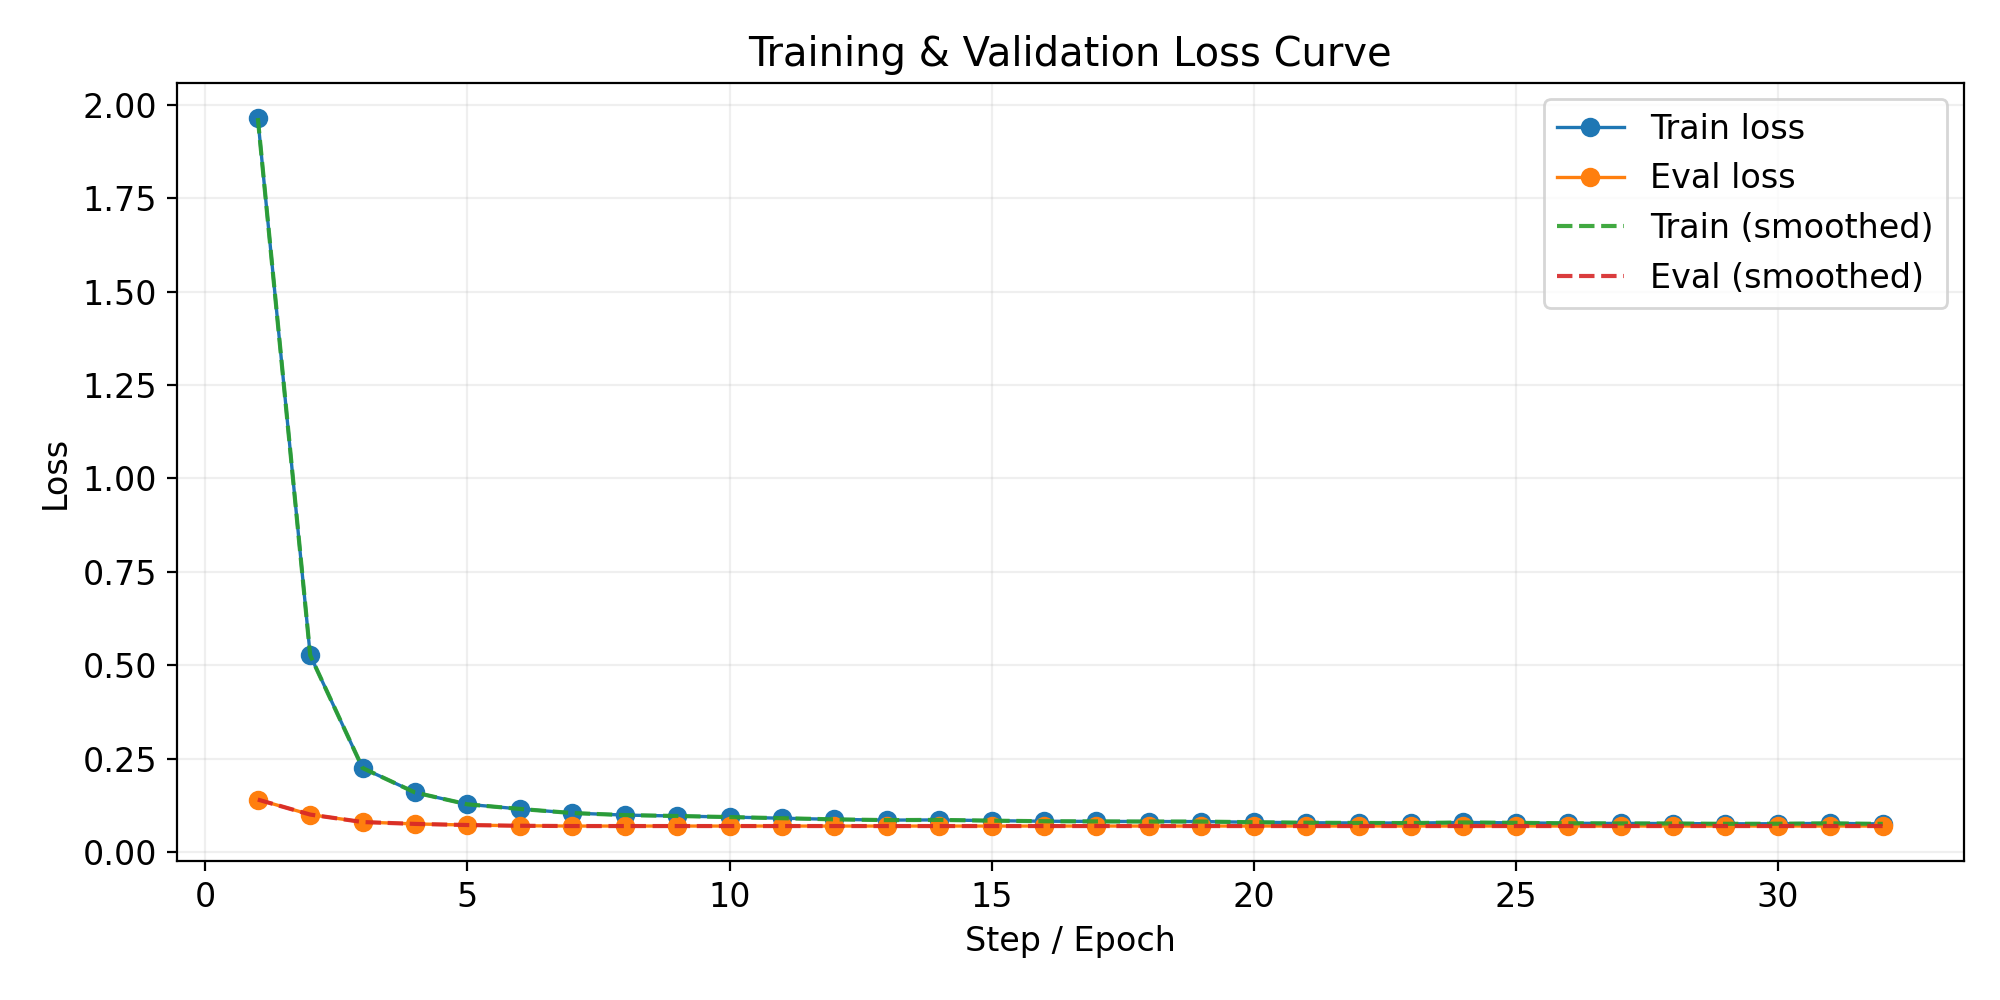

In [54]:
from IPython.display import Image
Image(filename="loss_curves.png")
